# Find and retrieve Landsat imagery

This notebook demonstrates how to:
- intersect Landsat scenes with a flight track using
[BigQuery](https://cloud.google.com/storage/docs/public-datasets/landsat)
- retrieve and visualized Landsat scenes

This notebook relies on optional dependencies in the `leo` group (`pip install pycontrails[leo]`).

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
import pyproj

from pycontrails.core import Flight
from pycontrails.datalib import landsat

### Intersect Landsat scenes with IAGOS flight

Intersecting Landsat scenes with flight tracks requires a Google Cloud account and project with access to the [BigQuery API](https://cloud.google.com/bigquery?hl=en). Users without BigQuery API access can skip this section.

In [2]:
df = pd.read_csv("data/iagos-flight-landsat.csv")

In [3]:
flight = Flight(data=df).resample_and_fill("1min")

In [4]:
scenes = landsat.intersect(flight)
scenes

,base_url,sensing_time
0,gs://gcp-public-data-landsat/LC08/01/124/048/L...,2019-01-12 03:05:55.144026+00:00
1,gs://gcp-public-data-landsat/LC08/01/124/049/L...,2019-01-12 03:06:19.047773+00:00


### Retrieve and visualize Landsat scene

This section retrieves Landsat imagery from a [Google Cloud public dataset](https://cloud.google.com/storage/docs/public-datasets/landsat). Retrieval uses anonymous access, so this section of the notebook can be run by users without a Google Cloud account.

The `base_url` used here corresponds to the first scene found in the previous section. In the second scene, the flight is in a region with missing imagery. Both `base_url` and `sensing_time` are hard-coded so this section can be run independently of the previous section.

In [5]:
base_url = "gs://gcp-public-data-landsat/LC08/01/124/048/LC08_L1TP_124048_20190112_20190131_01_T1"
sensing_time = pd.Timestamp("2019-01-12 03:05:55.144026+00:00")

The IAGOS flight is in an ISSR at the time of imagery acquisition:

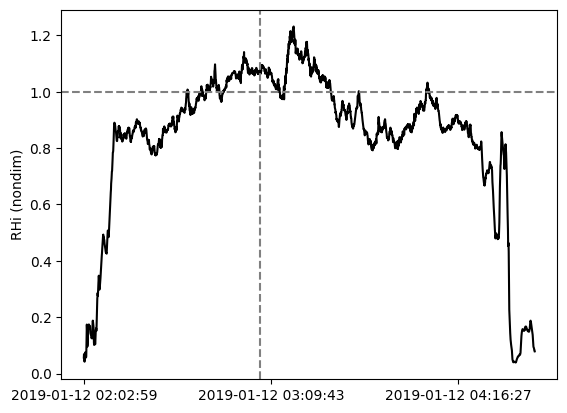

In [6]:
plt.plot(df["time"], df["rhi"], "k-")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time.strftime("%Y-%m-%d %H:%M:%S"), color="gray", ls="--");

#### True-color image

We first download bands 2, 3, and 4. These are used to create a true-color image.

In [7]:
handler = landsat.Landsat(base_url, bands=["B2", "B3", "B4"])
ds = handler.get()
ds

<xarray.Dataset>
Dimensions:  (y: 7801, x: 7651)
Coordinates:
  * y        (y) float64 1.801e+06 1.801e+06 1.801e+06 ... 2.035e+06 2.035e+06
  * x        (x) float64 1.896e+05 1.896e+05 1.897e+05 ... 4.191e+05 4.191e+05
Data variables:
    B2       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    B4       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    B3       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

We then generate and plot true-color image.

In [8]:
rgb, crs, extent = landsat.extract_landsat_visualization(ds, color_scheme="true")

In [9]:
# crs artifact can be used to project flight latitude and longitude into image coordinates
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_lon = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: pd.Timestamp(t).timestamp()),
    df["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: pd.Timestamp(t).timestamp()),
    df["latitude"],
)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

/opt/homebrew/Caskroom/miniforge/base/envs/contrails/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


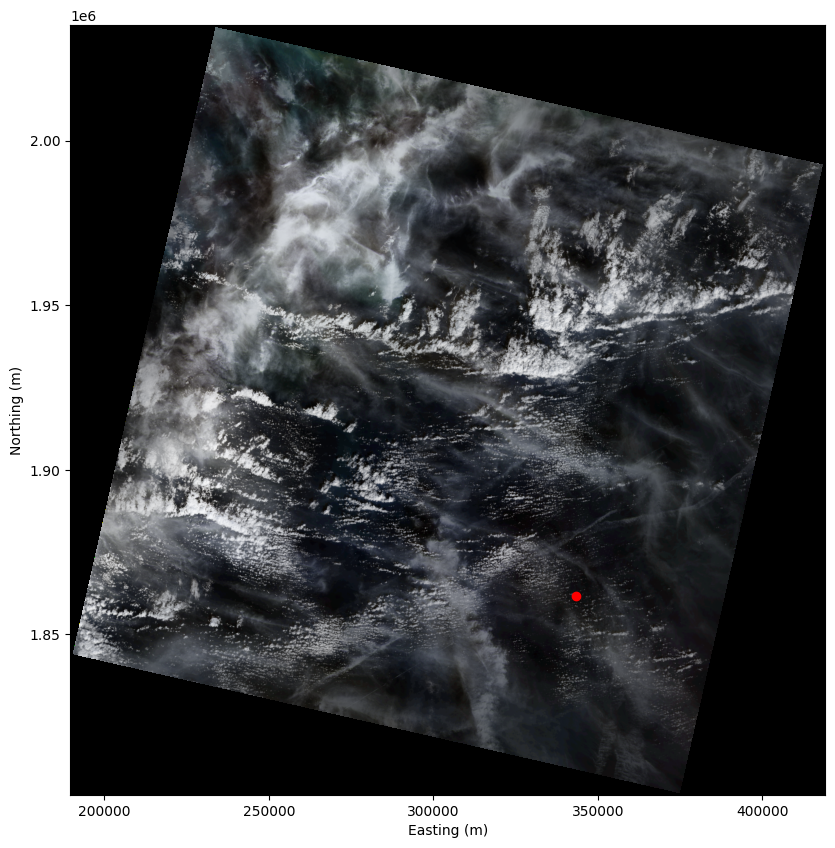

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

If we zoom in, we can see the aircraft and contrail! The aircraft is offset slightly from its projected position because Landsat imagery is geolocated at the surface.

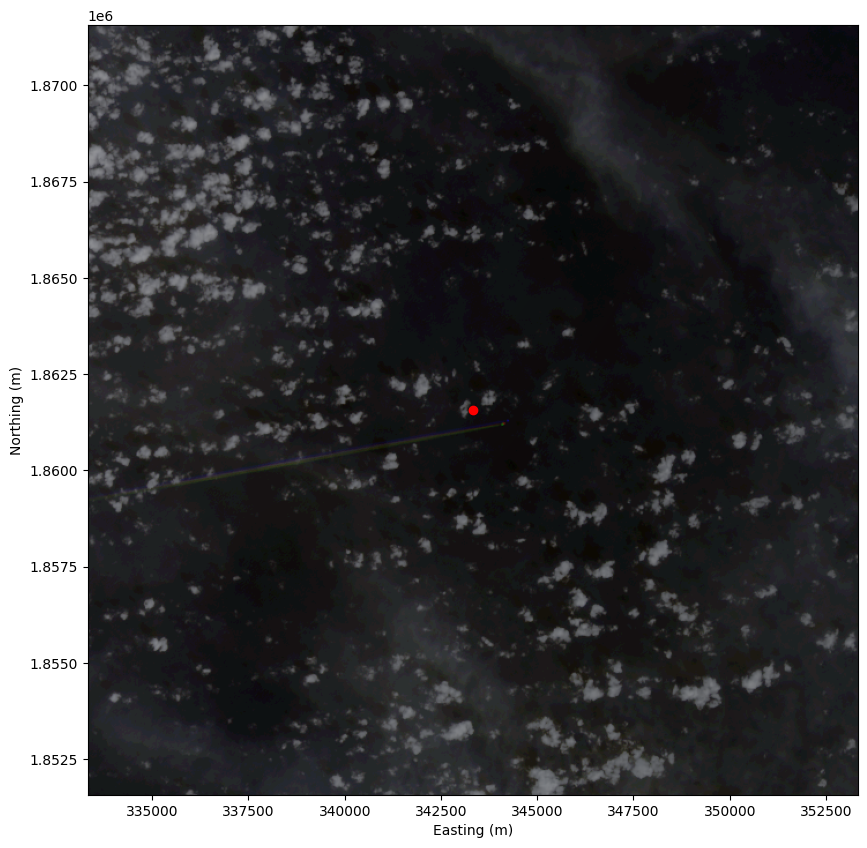

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlim([flight_x - 10e3, flight_x + 10e3])
plt.ylim([flight_y - 10e3, flight_y + 10e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

#### False-color thermal image

Finally, we download bands 9, 10, and 11 and use them to create a false-color image using a color scheme designed for contrail detection by [Google Research](https://research.google/pubs/a-human-labeled-landsat-contrails-dataset/).

In [12]:
handler = landsat.Landsat(base_url, bands=["B9", "B10", "B11"])
ds = handler.get()

In [13]:
rgb, crs, extent = landsat.extract_landsat_visualization(ds, color_scheme="google_contrails")

In [14]:
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

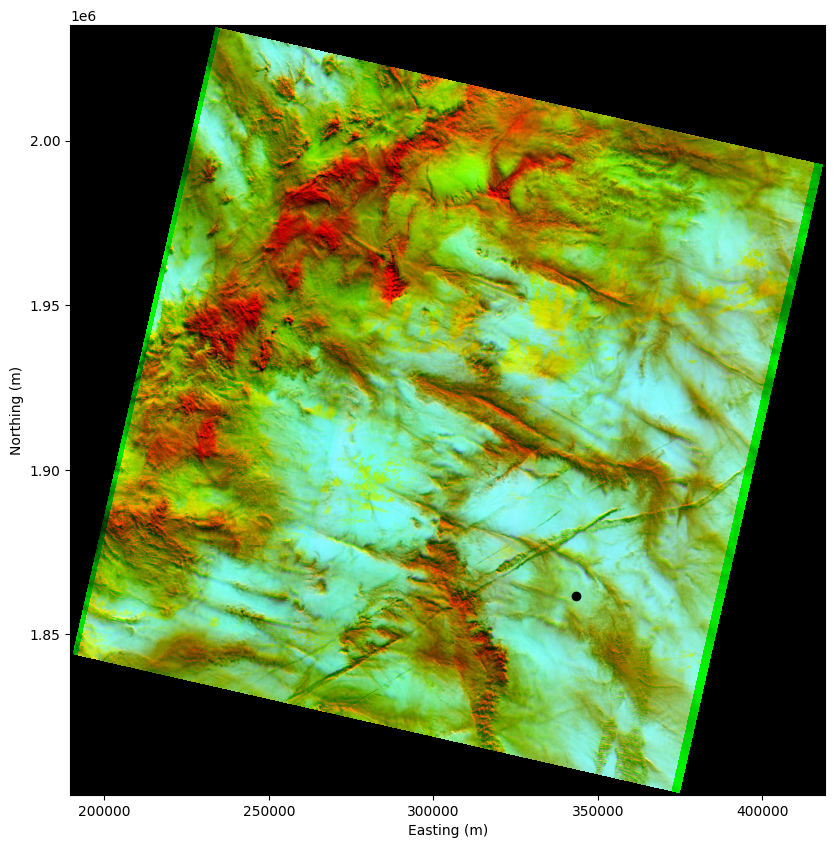

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ko")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");